## Plant seedling Classification using Deep CNN in Keras

### The Plant Species dataset contains 4750 128*128 color images in 12 different classes

In [1]:
#@title Default title text
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Import the libraries, load the dataset, print the shape of the data and visualize the images

In [ ]:
import numpy as np
img_array=np.load('/content/drive/My Drive/images.npy')



In [ ]:
## load the labels.csv file
import pandas as pd
labels=pd.read_csv('/content/drive/My Drive/Labels.csv')

In [ ]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

In [ ]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


### Visualize the Images

Small-flowered Cranesbill


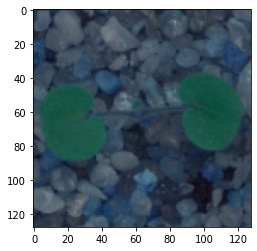

*****************************************************
Fat Hen


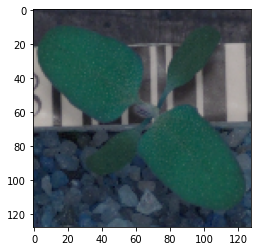

*****************************************************
Shepherds Purse


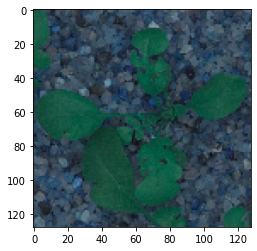

*****************************************************
Common Chickweed


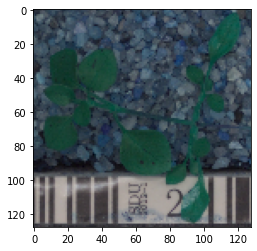

*****************************************************
Common Chickweed


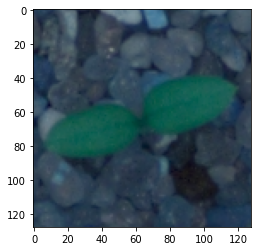

*****************************************************


In [ ]:
for i in range(0,2500,500):
  print(labels.Label[i])
  plt.imshow(img_array[i],cmap='gray')
  plt.show()
  print("*****************************************************")

###Shape of Data

In [ ]:
labels.shape

(4750, 1)

In [ ]:
img_array.shape

(4750, 128, 128, 3)

4750 samples, 128*128 color images

4750 labels

## Data PreProcessing
### Normalization, Gaussian Blurring, Resizing and Removing Background Noise (Masking)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import cv2
## create a zeros np array to hold the final pre-processed Images
X=np.zeros((len(img_array),64,64,3),dtype='float64')
## Loop thru the Images array
for i,img in enumerate(img_array):
  ## Backgroung noise removal and Masking
  ## convert the colorspace to HSV (better color detection than RGB space)
  img_hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  sensitivity=35

  lower_hsv=np.array([60-sensitivity,100,50])

  upper_hsv=np.array([60+sensitivity,255,255])
  ## The inRange Function returns a binary mask , where the white pixels represent the pixels that fall into the range and black pixels do not!
  mask=cv2.inRange(img_hsv,lower_hsv,upper_hsv)
  ## Ellipse shape Kernel to perform morphological trnsformation
  kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
  ## MORPH_CLOSE is useful in closing small holes/black points in foreground objects
  mask=cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel)
  ## Only the intersecting parts of the image with the mask created is captured
  output=cv2.bitwise_and(img,img,mask=mask)
  ## the masked image is blurred to remove further digital noise
  img_blur=cv2.GaussianBlur(output,(0,0),3)
  ## Resizing the image
  img_resize=cv2.resize(img_blur,(64,64))
  ## Adding the Pre-Processed Image to the Numpy Array
  X[i]=img_resize
  ## X contains all the Pre Processed Images

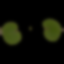

In [ ]:
## Visualise the PreProcessed Image
cv2_imshow(X[0])

## OneHotEncode the Output Labels

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
## convert the categorical labels into integers
le=LabelEncoder()
y_lab=le.fit_transform(labels['Label'])
labels=le.inverse_transform(y_lab)
df=pd.DataFrame({'Integers':y_lab,'Labels':labels})
df=df.drop_duplicates()


y=tf.keras.utils.to_categorical(y_lab,num_classes=12)
df=df.sort_values(by='Integers',ignore_index=True)
df

,Integers,Labels
0,0,Black-grass
1,1,Charlock
2,2,Cleavers
3,3,Common Chickweed
4,4,Common wheat
5,5,Fat Hen
6,6,Loose Silky-bent
7,7,Maize
8,8,Scentless Mayweed
9,9,Shepherds Purse


## Visualise the one hot encoded labels (y)

In [ ]:
print(y[1000])
print(y[500])
print(y[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


## Split the dataset into Train, Test and Validation set

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=30)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5,random_state=20)


In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

## Checking the shape of the Inputs to the CNN

In [ ]:
print("Shape of Input data to CNN {}".format(X_train.shape))

Shape of Input data to CNN (3325, 64, 64, 3)


## Build CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense,Dropout


## CNN Architecture

In [ ]:
## Bulid a CNN Sequential Classifier
from tensorflow.keras.layers import BatchNormalization
Classifier=Sequential()

## Add a Convolution Layer
Classifier.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
Classifier.add(BatchNormalization())
## Add a Pooling Layer
Classifier.add(MaxPooling2D(pool_size=(2,2)))


## Add a Convolution Layer
Classifier.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='valid'))
Classifier.add(BatchNormalization())

## Add a Pooling Layer
Classifier.add(MaxPooling2D(pool_size=(2,2)))
Classifier.add(Dropout(rate=0.4))


## Flatten the input to Fully connected Layer
Classifier.add(Flatten())

## Add a dense layer
Classifier.add(Dense(units=32,activation='relu'))

Classifier.add(Dropout(rate=0.5))

Classifier.add(Dense(units=128,activation='relu'))


Classifier.add(Dense(units=12,activation='softmax'))

Classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0

In [ ]:
Classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


## Fit the Model

In [ ]:
Classifier.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=40,batch_size=20)

Epoch 1/40
167/167 [==============================] - 34s 8ms/step - loss: 2.4665 - accuracy: 0.2058 - val_loss: 1.5667 - val_accuracy: 0.4811
Epoch 2/40
167/167 [==============================] - 1s 5ms/step - loss: 1.7489 - accuracy: 0.3730 - val_loss: 2.0414 - val_accuracy: 0.3548
Epoch 3/40
167/167 [==============================] - 1s 5ms/step - loss: 1.5895 - accuracy: 0.4436 - val_loss: 1.7571 - val_accuracy: 0.4783
Epoch 4/40
167/167 [==============================] - 1s 5ms/step - loss: 1.5695 - accuracy: 0.4648 - val_loss: 1.1991 - val_accuracy: 0.5764
Epoch 5/40
167/167 [==============================] - 1s 5ms/step - loss: 1.4185 - accuracy: 0.5286 - val_loss: 1.1624 - val_accuracy: 0.6227
Epoch 6/40
167/167 [==============================] - 1s 5ms/step - loss: 1.3681 - accuracy: 0.5241 - val_loss: 1.2355 - val_accuracy: 0.5820
Epoch 7/40
167/167 [==============================] - 1s 5ms/step - loss: 1.3103 - accuracy: 0.5525 - val_loss: 1.2542 - val_accuracy: 0.5792
Epoch

In [ ]:
Classifier.evaluate(X_test,y_test)

23/23 [==============================] - 0s 6ms/step - loss: 0.7318 - accuracy: 0.7598


[0.731780469417572, 0.7598314881324768]

## Make Predictions on X_test

In [ ]:
y_pred=Classifier.predict(X_test)

## Visualize Predictions


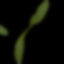

Predicted Label for X[2] is 11
Actual label for X[2] is 11
The Plant Species is 11    Sugar beet
Name: Labels, dtype: object
*******************************************************************************************


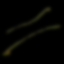

Predicted Label for X[3] is 6
Actual label for X[3] is 6
The Plant Species is 6    Loose Silky-bent
Name: Labels, dtype: object
*******************************************************************************************


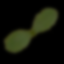

Predicted Label for X[33] is 8
Actual label for X[33] is 8
The Plant Species is 8    Scentless Mayweed
Name: Labels, dtype: object
*******************************************************************************************


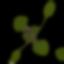

Predicted Label for X[36] is 3
Actual label for X[36] is 3
The Plant Species is 3    Common Chickweed
Name: Labels, dtype: object
*******************************************************************************************


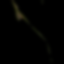

Predicted Label for X[59] is 0
Actual label for X[59] is 6
The Plant Species is 6    Loose Silky-bent
Name: Labels, dtype: object
*******************************************************************************************


In [ ]:
list_range=[2,3,33,36,59]


for i in list_range:
  cv2_imshow(X_test[i])

  print("Predicted Label for X[{}] is {}".format(i,y_pred[i].argmax()))
  
  print("Actual label for X[{}] is {}".format(i,y_test[i].argmax()))
  species=df['Labels'].loc[df['Integers']==y_test[i].argmax()]
  print("The Plant Species is {}".format(species))

  print ("*******************************************************************************************")


In [ ]:
from sklearn.metrics import confusion_matrix
##print(confusion_matrix(y_pred.argmax(),y_test.argmax()))
pred=np.argmax(y_pred,axis=1)
act=np.argmax(y_test,axis=1)
print(confusion_matrix(pred,act,labels=[0,1,2,3,4,5,6,7,8,9,10,11]))

[[22  0  0  0  3  0 23  0  1  0  0  0]
 [ 0 47  2  0  0  0  0  0  0  0  0  0]
 [ 0  8 35  0  0  1  0  0  0  0  0  1]
 [ 0  0  0 90  2  2  1  8  1  4  0  1]
 [ 7  0  1  0 14  0  1  0  1  0  0  0]
 [ 0  1  0  0  1 64  1  2  3  0  0  0]
 [15  0  0  0  5  0 51  0  1  0  0  0]
 [ 0  0  1  0  0  0  0 17  0  0  1  2]
 [ 0  2  5  6  4  4  0  1 70  6  1  3]
 [ 0  4  1  0  0  1  0  1  2 11  1  0]
 [ 0  3  0  2  0  0  0  1  1  4 76  1]
 [ 3  1  0  2  0  2  3  4  1  0  0 44]]


In [ ]:
print("***********Thank You*************")

***********Thank You*************
